In [ ]:
# Importing libraries

In [ ]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

from torch.utils.data import TensorDataset, DataLoader, random_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split


In [ ]:
# Hyperparameters

In [ ]:

# -------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128
EPOCHS = 8             # set small for quick runs; increase for better convergence
LR = 1e-3
WEIGHT_DECAY = 0.0
RNG_SEED = 42
torch.manual_seed(RNG_SEED)
np.random.seed(RNG_SEED)

In [ ]:
# Load the data

In [ ]:
from google.colab import files

# Upload train and test CSV files manually
uploaded = files.upload()



TRAIN_CSV = "mnist_train.csv"  # file you just uploaded
TEST_CSV  = "mnist_test.csv"
def load_mnist_from_csv(train_csv=TRAIN_CSV, test_csv=TEST_CSV):
    train_df = pd.read_csv(train_csv)
    test_df  = pd.read_csv(test_csv)

    # Train set
    y = train_df['label'].values.astype(np.int64)
    X = train_df.drop('label', axis=1).values.astype(np.float32) / 255.0

    # Test set
    if 'label' in test_df.columns:
        X_test = test_df.drop('label', axis=1).values.astype(np.float32) / 255.0
        y_test = test_df['label'].values.astype(np.int64)
    else:
        X_test = test_df.values.astype(np.float32) / 255.0
        y_test = None

    return (X, y), (X_test, y_test)

# Load data
(X, y), (X_test, y_test) = load_mnist_from_csv()
print("Loaded shapes:", X.shape, y.shape, X_test.shape)


Saving mnist_test.csv to mnist_test.csv
Saving mnist_train.csv to mnist_train.csv
Loaded shapes: (60000, 784) (60000,) (10000, 784)


In [ ]:
# Data Cleaning

In [ ]:
import numpy as np

# Check X
nan_X = np.isnan(X).any()
inf_X = np.isinf(X).any()
print(f"NaNs in X: {nan_X}")
print(f"Infs in X: {inf_X}")

# Check y
nan_y = np.isnan(y).any()
inf_y = np.isinf(y).any()
print(f"NaNs in y: {nan_y}")
print(f"Infs in y: {inf_y}")

# Optional: raise error if found
if nan_X or inf_X or nan_y or inf_y:
    raise ValueError("Found NaN or infinity in the dataset!")
else:
    print("No NaNs or infinities detected. Dataset is clean ✅")


NaNs in X: False
Infs in X: False
NaNs in y: False
Infs in y: False
No NaNs or infinities detected. Dataset is clean ✅


In [ ]:
# Visualization

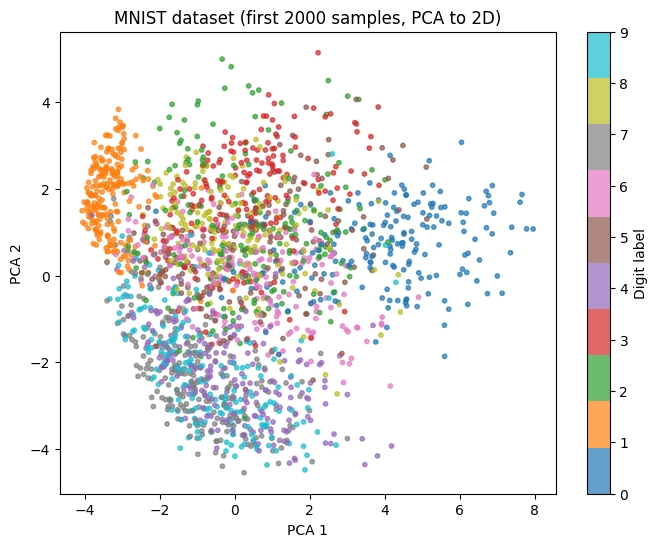

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Scatter plot with labels
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:2000, 0], X_pca[:2000, 1],
                      c=y[:2000], cmap="tab10", alpha=0.7, s=10)
plt.colorbar(scatter, label="Digit label")
plt.title("MNIST dataset (first 2000 samples, PCA to 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


In [ ]:
# Create train / val split

In [ ]:

dataset = TensorDataset(torch.from_numpy(X), torch.from_numpy(y))
n_total = len(dataset)
n_val = 5000
n_train = n_total - n_val
train_ds, val_ds = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(RNG_SEED))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

# Test loader if labels present
if y_test is not None:
    test_ds = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)
else:
    test_loader = None

In [ ]:
# Defines a configurable deep neural network (MLP)/ architecte

In [ ]:

def get_activation(name):
    name = name.lower()
    if name == 'relu':
        return nn.ReLU()
    if name == 'leaky_relu':
        return nn.LeakyReLU(0.01)
    if name == 'prelu':
        return nn.PReLU()
    if name == 'tanh':
        return nn.Tanh()
    if name == 'sigmoid':
        return nn.Sigmoid()
    raise ValueError(f"Unknown activation: {name}")

class MLP(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=256, n_hidden=2, activation='relu', num_classes=10, dropout=0.0):
        super().__init__()
        act_layer = get_activation(activation)
        layers = []
        in_dim = input_dim
        for i in range(n_hidden):
            layers.append(nn.Linear(in_dim, hidden_dim))
            layers.append(act_layer if not isinstance(act_layer, nn.PReLU) else nn.PReLU())  # PReLU needs instance per layer
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            in_dim = hidden_dim
        layers.append(nn.Linear(in_dim, num_classes))
        self.net = nn.Sequential(*layers)

        # weight init: He for ReLU-family, Xavier for tanh/sigmoid
        for m in self.net:
            if isinstance(m, nn.Linear):
                if activation in ['relu', 'leaky_relu', 'prelu']:
                    nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                else:
                    nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)

In [ ]:
# Define a function to Evaluate and train Model using default relu

In [ ]:
# -------------------------
def evaluate(model, loader, device=DEVICE):
    model.eval()
    correct = 0
    total = 0
    loss_fn = nn.CrossEntropyLoss()
    total_loss = 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device).float()
            yb = yb.to(device)
            out = model(xb)
            total_loss += loss_fn(out, yb).item()*xb.size(0)
            preds = out.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += xb.size(0)
    return total_loss/total, correct/total

def train_one_model(activation='relu', n_hidden=2, hidden_dim=256, epochs=EPOCHS, lr=LR, record_gradients=True):
    model = MLP(input_dim=784, hidden_dim=hidden_dim, n_hidden=n_hidden, activation=activation).to(DEVICE)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)
    loss_fn = nn.CrossEntropyLoss()

    history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'grad_norms': defaultdict(list)}
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        n_batches = 0
        # accumulate gradient norms per layer per epoch
        layer_grad_accumulator = [0.0 for _ in model.net if isinstance(_, nn.Linear)]
        layer_counts = [0 for _ in layer_grad_accumulator]

        for xb, yb in train_loader:
            xb = xb.to(DEVICE).float()
            yb = yb.to(DEVICE)
            out = model(xb)
            loss = loss_fn(out, yb)
            opt.zero_grad()
            loss.backward()

            # record gradient norms per Linear layer
            if record_gradients:
                lin_idx = 0
                for m in model.net:
                    if isinstance(m, nn.Linear):
                        if m.weight.grad is not None:
                            gnorm = m.weight.grad.data.norm().item()
                            layer_grad_accumulator[lin_idx] += gnorm
                            layer_counts[lin_idx] += 1
                        lin_idx += 1

            opt.step()
            epoch_loss += loss.item()
            n_batches += 1

        # finish epoch stats
        avg_train_loss = epoch_loss / n_batches
        val_loss, val_acc = evaluate(model, val_loader)
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if record_gradients:
            # compute average grad norm per layer this epoch
            avg_grad_norms = [layer_grad_accumulator[i]/max(1, layer_counts[i]) for i in range(len(layer_grad_accumulator))]
            for i, g in enumerate(avg_grad_norms):
                history['grad_norms'][f'layer_{i}'].append(g)

        print(f"[{activation} | hidden={n_hidden} | epoch {epoch+1}/{epochs}] "
      f"train_loss={avg_train_loss:.4f} val_loss={val_loss:.4f} val_acc={val_acc:.4f}")


    return model, history



In [ ]:
# Define diffrent aitvation function

In [ ]:
def run_depth_experiments(depths, activation='relu', hidden_dim=256, epochs=8):
    results = {}
    for d in depths:
        print(f"Training model with depth={d}")
        model, history = train_one_model(
            n_hidden=d,
            hidden_dim=hidden_dim,
            activation=activation,
            epochs=epochs
        )
        results[d] = {
            "train_loss": history["train_loss"],
            "val_loss": history["val_loss"],
            "val_acc": history["val_acc"],
            "grad_norms": history["grad_norms"],
            "model": model   # 👈 store model for scatter plot
        }
    return results


def run_relu_variants(variants=['relu','leaky_relu','prelu'], n_hidden=8):
    return run_activation_comparison(variants, n_hidden=n_hidden)




In [ ]:
# Define function for Visualization

In [ ]:

def plot_loss_acc(result_dict, title_suffix=""):
    plt.figure(figsize=(10,4))
    # loss
    plt.subplot(1,2,1)
    for k, hist in result_dict.items():
        plt.plot(hist['train_loss'], label=f"{k}-train")
        plt.plot(hist['val_loss'], '--', label=f"{k}-val")
    plt.title("Loss "+title_suffix)
    plt.xlabel("Epoch")
    plt.legend()
    # acc
    plt.subplot(1,2,2)
    for k, hist in result_dict.items():
        plt.plot(hist['val_acc'], label=f"{k}")
    plt.title("Validation Accuracy "+title_suffix)
    plt.xlabel("Epoch")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_grad_norms(history, title_suffix=""):
    # history is one model's history
    layers = sorted(history['grad_norms'].keys(), key=lambda s:int(s.split('_')[1]))
    plt.figure(figsize=(8,4))
    for i, l in enumerate(layers):
        plt.plot(history['grad_norms'][l], label=l)
    plt.title("Per-layer gradient norms "+title_suffix)
    plt.xlabel("Epoch")
    plt.ylabel("Gradient norm")
    plt.legend()
    plt.show()


In [ ]:
import torch

def plot_scatter_with_predictions(X, y, model, n_samples=2000, device=DEVICE):
    """
    X: numpy array of shape (N, 784)
    y: numpy array of labels
    model: PyTorch model
    """
    # Reduce to 2D
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X[:n_samples])

    # Predict labels using PyTorch
    model.eval()
    with torch.no_grad():
        xb = torch.from_numpy(X[:n_samples]).float().to(device)
        outputs = model(xb)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

    plt.figure(figsize=(14,6))

    # True labels
    plt.subplot(1,2,1)
    scatter1 = plt.scatter(X_pca[:,0], X_pca[:,1], c=y[:n_samples],
                           cmap="tab10", alpha=0.7, s=10)
    plt.colorbar(scatter1, label="True label")
    plt.title("True labels (PCA projection)")

    # Predicted labels
    plt.subplot(1,2,2)
    scatter2 = plt.scatter(X_pca[:,0], X_pca[:,1], c=preds,
                           cmap="tab10", alpha=0.7, s=10)
    plt.colorbar(scatter2, label="Predicted label")
    plt.title("Predicted labels (PCA projection)")

    plt.show()

    # Accuracy on this subset
    acc = (preds == y[:n_samples]).mean()
    print(f"Accuracy on {n_samples} samples (scatter data): {acc:.4f}")


In [ ]:
# Execute d/f activation function and visualization

Training with activation=sigmoid
[sigmoid | hidden=8 | epoch 1/8] train_loss=1.6991 val_loss=1.2409 val_acc=0.4272
[sigmoid | hidden=8 | epoch 2/8] train_loss=0.9955 val_loss=0.6524 val_acc=0.7766
[sigmoid | hidden=8 | epoch 3/8] train_loss=0.4354 val_loss=0.3685 val_acc=0.8986
[sigmoid | hidden=8 | epoch 4/8] train_loss=0.2647 val_loss=0.2387 val_acc=0.9330
[sigmoid | hidden=8 | epoch 5/8] train_loss=0.2025 val_loss=0.2359 val_acc=0.9326
[sigmoid | hidden=8 | epoch 6/8] train_loss=0.1695 val_loss=0.2011 val_acc=0.9436
[sigmoid | hidden=8 | epoch 7/8] train_loss=0.1438 val_loss=0.1882 val_acc=0.9482
[sigmoid | hidden=8 | epoch 8/8] train_loss=0.1304 val_loss=0.1893 val_acc=0.9462
Training with activation=tanh
[tanh | hidden=8 | epoch 1/8] train_loss=0.3116 val_loss=0.2045 val_acc=0.9364
[tanh | hidden=8 | epoch 2/8] train_loss=0.1745 val_loss=0.1724 val_acc=0.9498
[tanh | hidden=8 | epoch 3/8] train_loss=0.1318 val_loss=0.1616 val_acc=0.9556
[tanh | hidden=8 | epoch 4/8] train_loss=0.1

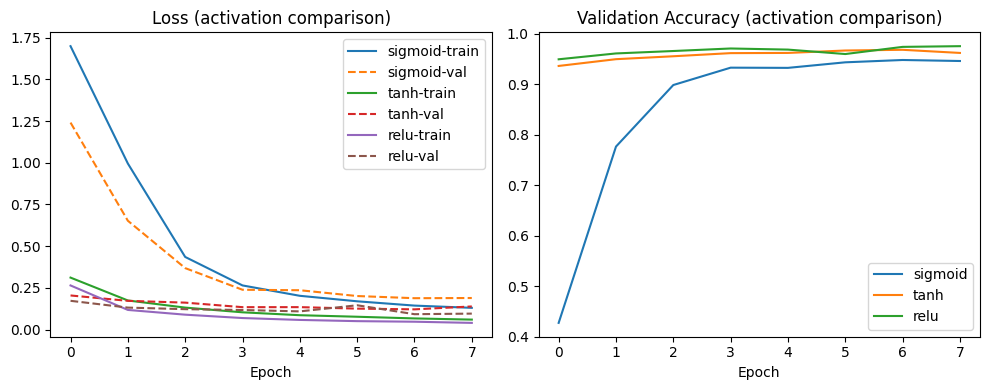


Scatter plot comparison for sigmoid


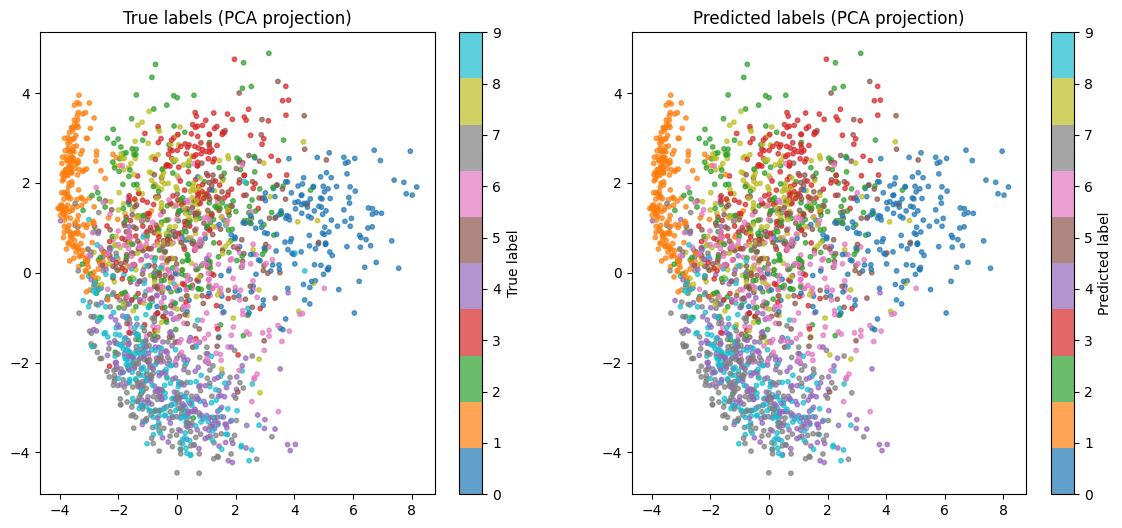

Accuracy on 2000 samples (scatter data): 0.9605

Scatter plot comparison for tanh


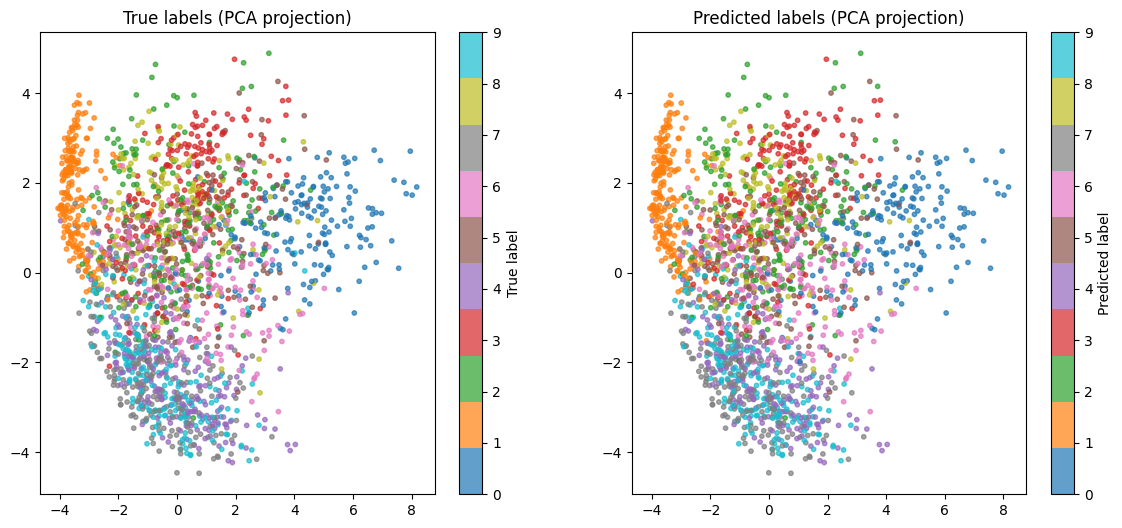

Accuracy on 2000 samples (scatter data): 0.9765

Scatter plot comparison for relu


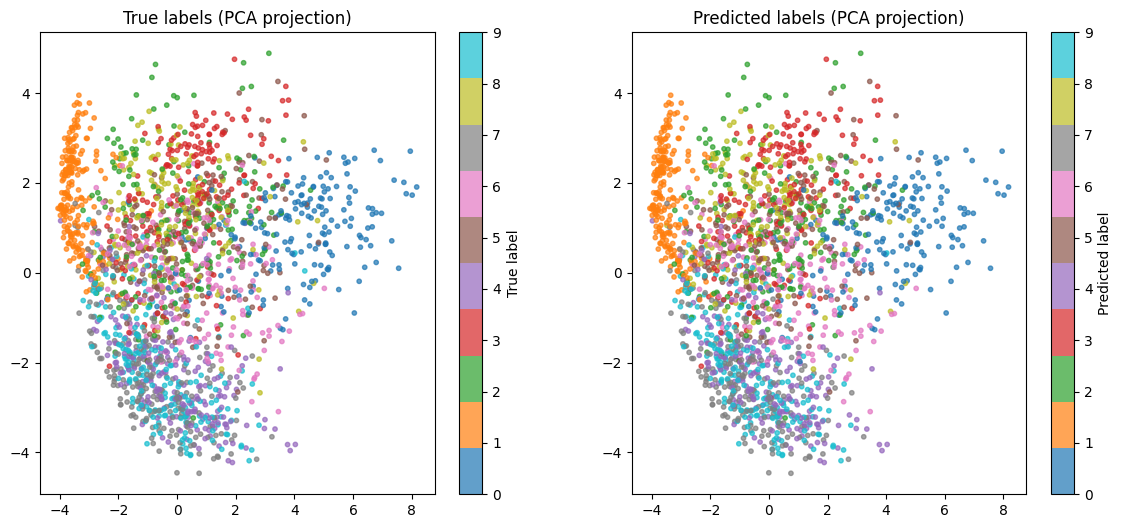

Accuracy on 2000 samples (scatter data): 0.9845

Grad norms for sigmoid


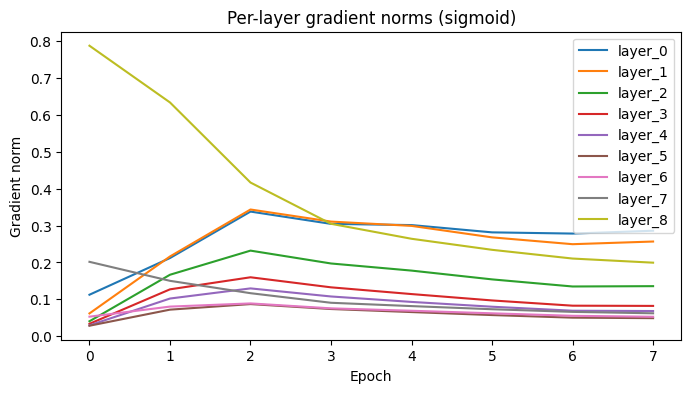


Grad norms for tanh


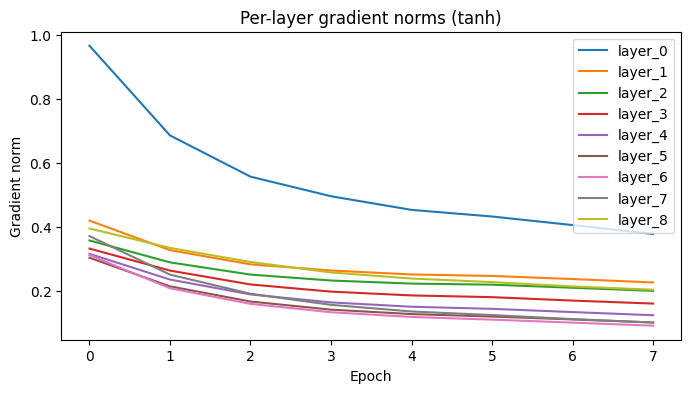


Grad norms for relu


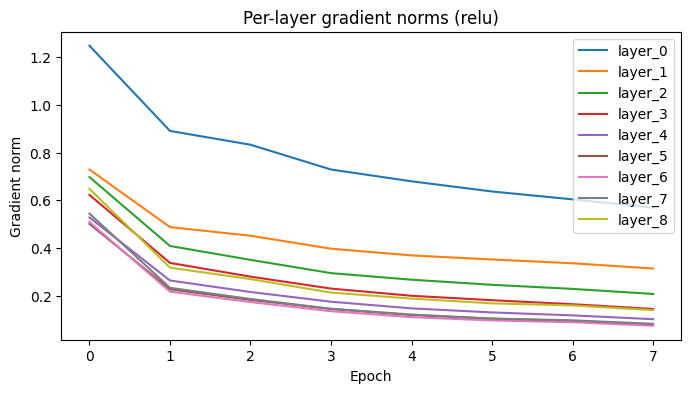

Training with activation=relu
[relu | hidden=8 | epoch 1/5] train_loss=0.2652 val_loss=0.1452 val_acc=0.9560
[relu | hidden=8 | epoch 2/5] train_loss=0.1189 val_loss=0.1168 val_acc=0.9636
[relu | hidden=8 | epoch 3/5] train_loss=0.0836 val_loss=0.1182 val_acc=0.9668
[relu | hidden=8 | epoch 4/5] train_loss=0.0661 val_loss=0.1240 val_acc=0.9672
[relu | hidden=8 | epoch 5/5] train_loss=0.0573 val_loss=0.1257 val_acc=0.9680
Training with activation=leaky_relu
[leaky_relu | hidden=8 | epoch 1/5] train_loss=0.2615 val_loss=0.1672 val_acc=0.9526
[leaky_relu | hidden=8 | epoch 2/5] train_loss=0.1137 val_loss=0.1224 val_acc=0.9660
[leaky_relu | hidden=8 | epoch 3/5] train_loss=0.0857 val_loss=0.1074 val_acc=0.9700
[leaky_relu | hidden=8 | epoch 4/5] train_loss=0.0680 val_loss=0.1314 val_acc=0.9634
[leaky_relu | hidden=8 | epoch 5/5] train_loss=0.0543 val_loss=0.0990 val_acc=0.9744
Training with activation=prelu
[prelu | hidden=8 | epoch 1/5] train_loss=0.2572 val_loss=0.1525 val_acc=0.9554
[pr

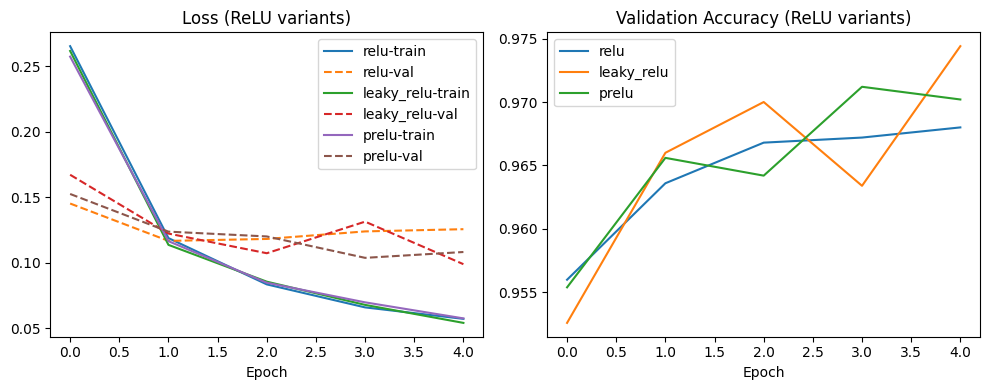


Scatter plot comparison for relu


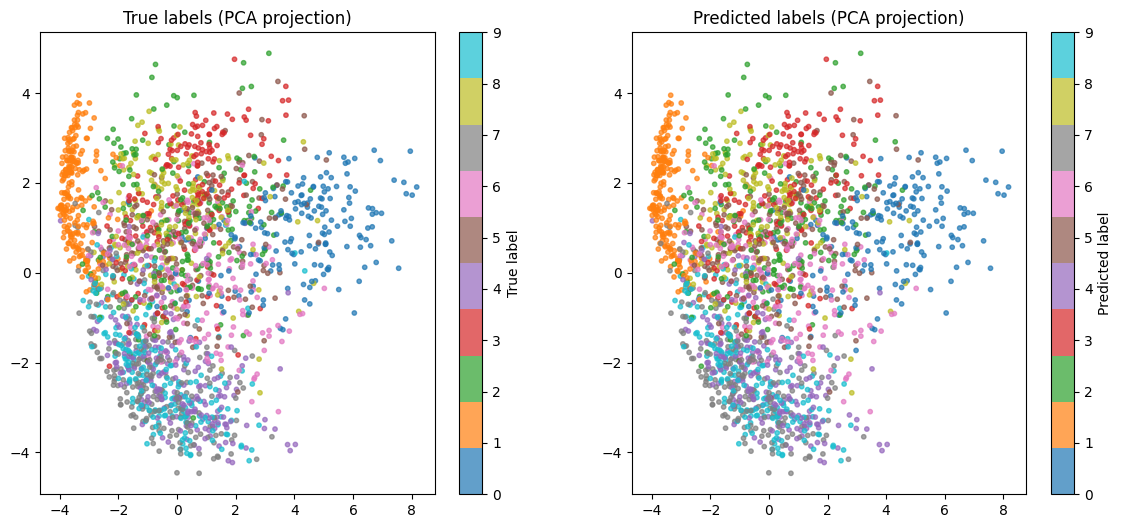

Accuracy on 2000 samples (scatter data): 0.9805

Scatter plot comparison for leaky_relu


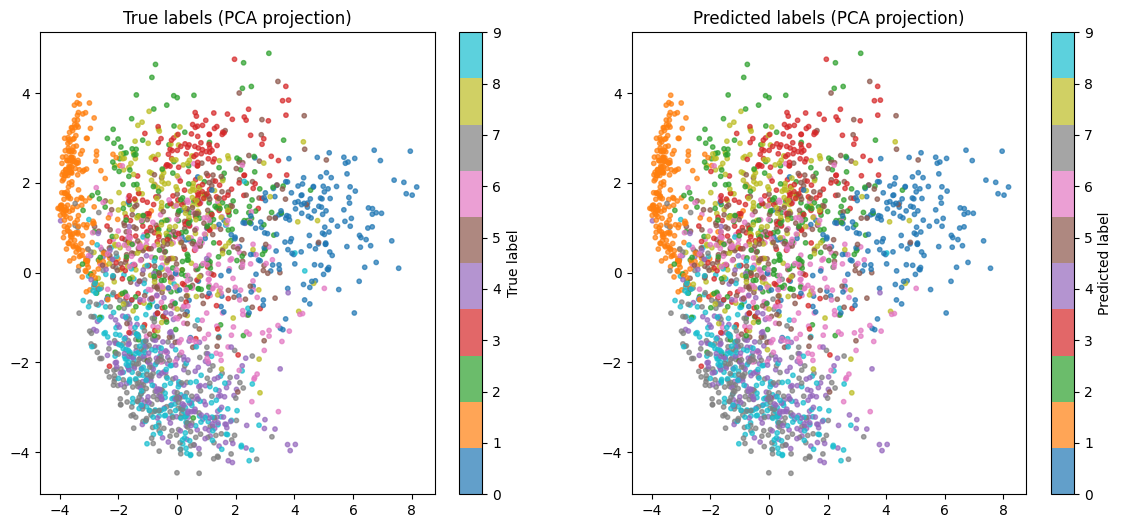

Accuracy on 2000 samples (scatter data): 0.9880

Scatter plot comparison for prelu


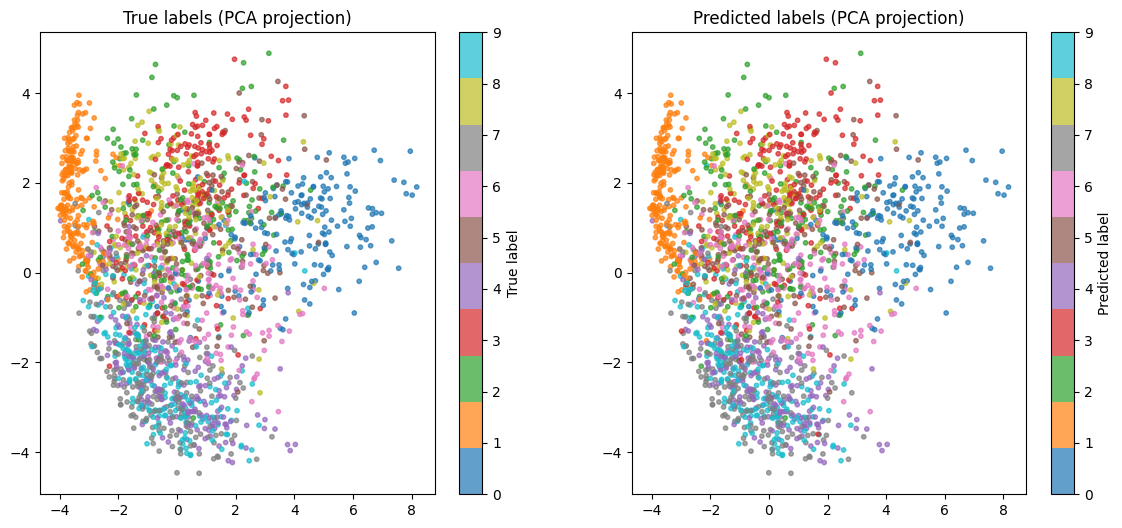

Accuracy on 2000 samples (scatter data): 0.9830
Training model with depth=2
[relu | hidden=2 | epoch 1/8] train_loss=0.2627 val_loss=0.1428 val_acc=0.9556
[relu | hidden=2 | epoch 2/8] train_loss=0.1006 val_loss=0.1098 val_acc=0.9644
[relu | hidden=2 | epoch 3/8] train_loss=0.0645 val_loss=0.1020 val_acc=0.9698
[relu | hidden=2 | epoch 4/8] train_loss=0.0461 val_loss=0.0832 val_acc=0.9748
[relu | hidden=2 | epoch 5/8] train_loss=0.0332 val_loss=0.0791 val_acc=0.9758
[relu | hidden=2 | epoch 6/8] train_loss=0.0250 val_loss=0.0912 val_acc=0.9750
[relu | hidden=2 | epoch 7/8] train_loss=0.0244 val_loss=0.0822 val_acc=0.9754
[relu | hidden=2 | epoch 8/8] train_loss=0.0180 val_loss=0.1007 val_acc=0.9714
Training model with depth=8
[relu | hidden=8 | epoch 1/8] train_loss=0.2658 val_loss=0.1519 val_acc=0.9562
[relu | hidden=8 | epoch 2/8] train_loss=0.1149 val_loss=0.1348 val_acc=0.9612
[relu | hidden=8 | epoch 3/8] train_loss=0.0827 val_loss=0.1080 val_acc=0.9682
[relu | hidden=8 | epoch 4/

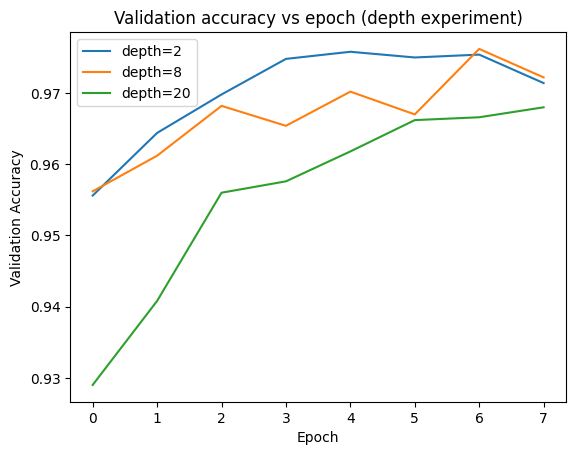


Scatter plot comparison for depth=2


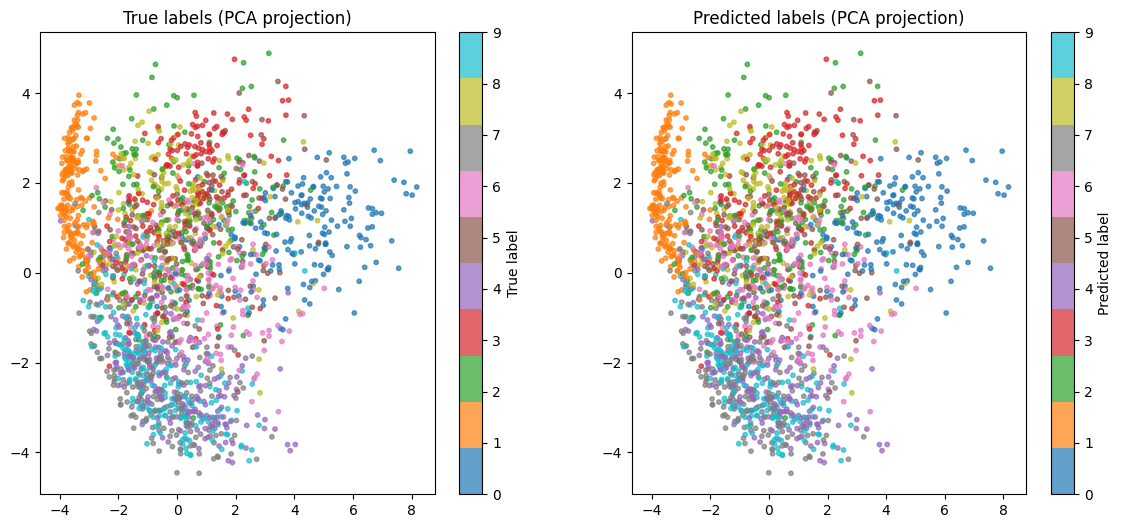

Accuracy on 2000 samples (scatter data): 0.9950

Scatter plot comparison for depth=8


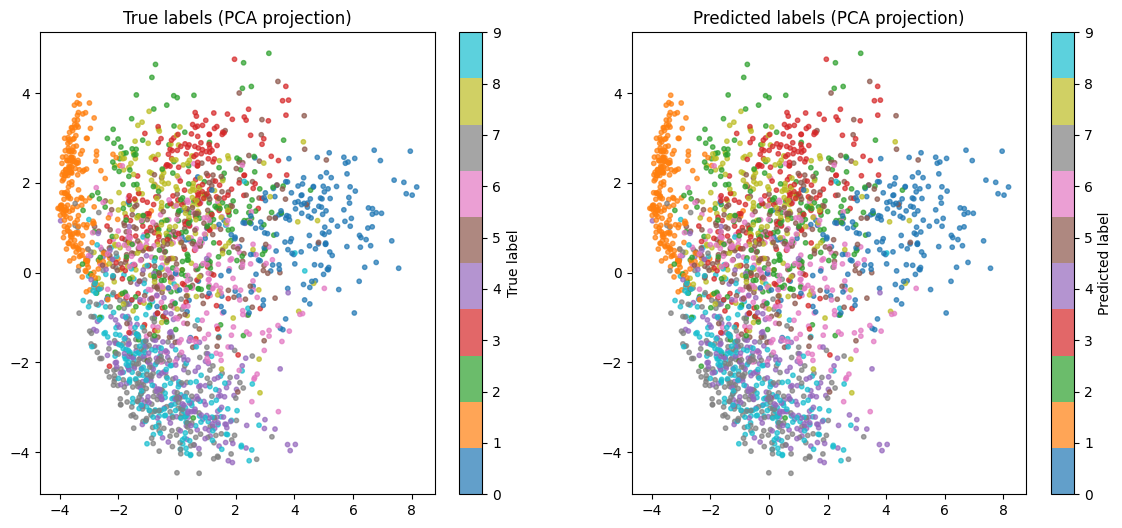

Accuracy on 2000 samples (scatter data): 0.9925

Scatter plot comparison for depth=20


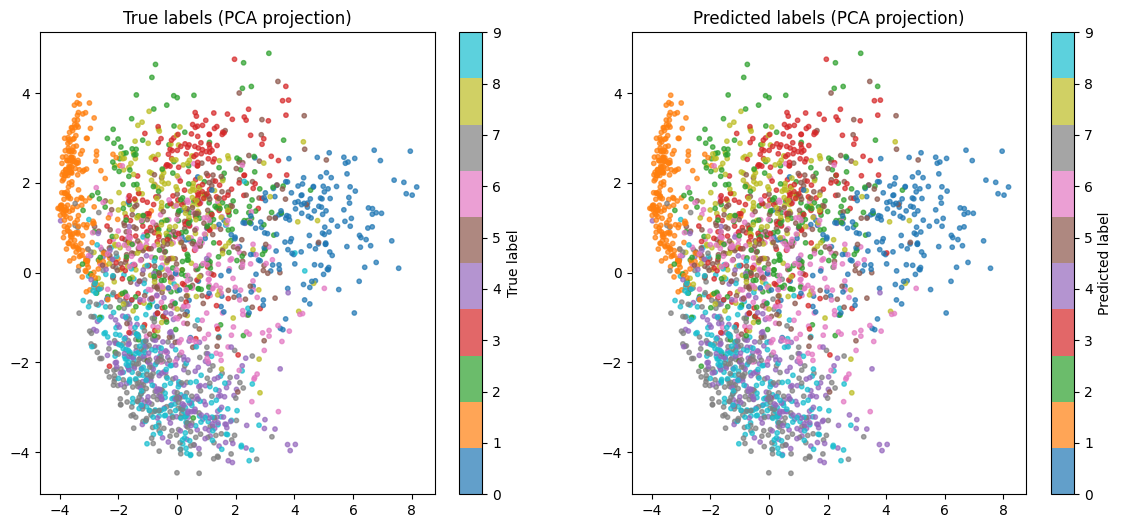

Accuracy on 2000 samples (scatter data): 0.9770


In [ ]:
# Example: run a short activation comparison (sigmoid, tanh, relu)
if __name__ == "__main__":
    # Run activation comparison for 8 epochs
    act_results = run_activation_comparison(['sigmoid','tanh','relu'], n_hidden=8, epochs=8)

    # Plot validation accuracy curves
    plot_loss_acc(act_results, title_suffix="(activation comparison)")

    # Scatter plots (PyTorch-compatible)
    for activation, res in act_results.items():
        print(f"\nScatter plot comparison for {activation}")
        best_model = res["model"]
        plot_scatter_with_predictions(X, y, best_model, n_samples=2000)

    # Plot grad norms for each activation
    for k, h in act_results.items():
        print("\nGrad norms for", k)
        plot_grad_norms(h, title_suffix=f"({k})")

    # Run ReLU variants (optional)
    relu_results = run_relu_variants(['relu','leaky_relu','prelu'], n_hidden=8)
    plot_loss_acc(relu_results, title_suffix="(ReLU variants)")

    # Scatter plot comparison for ReLU variants
    for activation, res in relu_results.items():
        print(f"\nScatter plot comparison for {activation}")
        best_model = res['model']
        plot_scatter_with_predictions(X, y, best_model, n_samples=2000)

    # Run depth experiments (optional)
    depth_results = run_depth_experiments(depths=[2,8,20], activation='relu')

    # Plot depth results (accuracy)
    plt.figure()
    for d, h in depth_results.items():
        plt.plot(h['val_acc'], label=f"depth={d}")
    plt.title("Validation accuracy vs epoch (depth experiment)")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy")
    plt.legend()
    plt.show()

    # Scatter plot comparison for depth experiments
    for depth, res in depth_results.items():
        print(f"\nScatter plot comparison for depth={depth}")
        best_model = res['model']
        plot_scatter_with_predictions(X, y, best_model, n_samples=2000)
+